# Linear Models

In [2]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get Data

In [3]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [4]:
# Search for all functional connectivity files and read them into a
# numpy array.
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]

print("Number of functional connectivities:", len(fcs))
print("Number of features (connections):", fcs["NDARAP912JK3"].shape[0])

Number of functional connectivities: 825
Number of features (connections): 34716


## Get Labels

In [5]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects_with_WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path, index_col='assessment WISC,EID')
# display(wisc_labels)

In [6]:
subject_ids = wisc_labels.index
measure_text = "WISC_Vocab_Scaled"
measure_col = f'assessment WISC,{measure_text}'
# measure_text = "Age"
# measure_col = 'assessment Basic_Demos,Age'

fc_matrices = []
measures = []
ages = []

for subject_id in subject_ids:
    if subject_id not in fcs:
        continue
    
    fc_matrices.append(fcs[subject_id])
    measures.append(wisc_labels.at[subject_id, measure_col])
    ages.append(wisc_labels.at[subject_id, 'assessment Basic_Demos,Age'])
    
print("Num subjects with measures:", len(measures))

Num subjects with measures: 577


In [6]:
X = np.array(fc_matrices)
y = np.array(measures)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (577, 34716) y shape: (577,)


## Dimensionality Reduction
I'm following the guide here: <https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html>.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [31]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X, y)

pls = PLSRegression(n_components=1)
pls.fit(X, y)

PLSRegression(n_components=1)

In [32]:
pca = pcr.named_steps['pca']
X_pca = pca.transform(X)

print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))
print(pca.components_.shape)
print(X_pca.shape)

X_pls = pls.transform(X)
print(X_pls.shape)

[0.20447944] 0.20447944
(1, 34716)
(577, 1)
(577, 1)


In [33]:
reg = pcr.named_steps['linearregression']
y_pcr_pred = reg.predict(X_pca)
y_pls_pred = pls.predict(X)

print("PCR Coef:", reg.coef_)
print("PCR r^2:", reg.score(X_pca, y))
print("PLS r^2:", pls.score(X, y))

PCR Coef: [-0.00144226]
PCR r^2: 0.00031318047203332533
PLS r^2: 0.09997688717376452


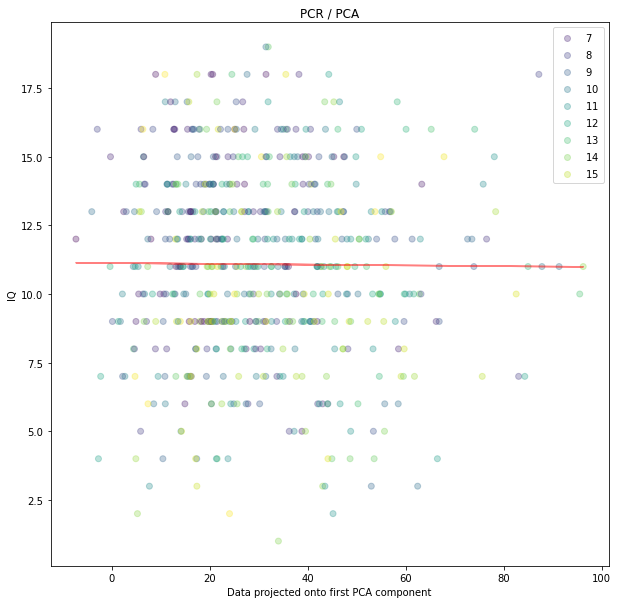

In [34]:
plt.figure(1, figsize=(10, 10))
scatter = plt.scatter(X_pca, y, c=ages, alpha=0.3, label='Ground Truth')
plt.plot(X_pca, y_pcr_pred, alpha=0.5, color='red', label="Predictions")
plt.title("PCR / PCA")
plt.xlabel('Data projected onto first PCA component')
plt.ylabel('IQ')
plt.legend(*scatter.legend_elements())
plt.show()

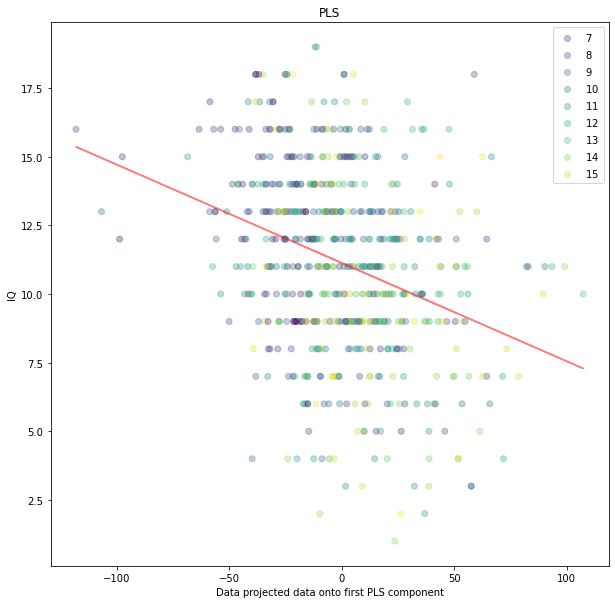

In [36]:
plt.figure(1, figsize=(10, 10))
plt.scatter(X_pls, y, c=ages, alpha=0.3, label='Ground Truth')
plt.plot(X_pls, y_pls_pred, alpha=0.5, color='red', label="Predictions")
plt.title("PLS")
plt.xlabel('Data projected data onto first PLS component')
plt.ylabel('IQ')
plt.legend(*scatter.legend_elements())
plt.show()

## Feature Selection

In [37]:
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, chi2, mutual_info_regression)

In [47]:
var_thres = VarianceThreshold(threshold=0.112)
X_var_thres = var_thres.fit_transform(X)

print(X_var_thres.shape)

(577, 1)


In [48]:
reg = LinearRegression().fit(X_var_thres, y)
y_var_thres = reg.predict(X_var_thres)

print("LR w/ Variance Threshold:", reg.score(X_var_thres, y))

LR w/ Variance Threshold: 0.0051182914759687614


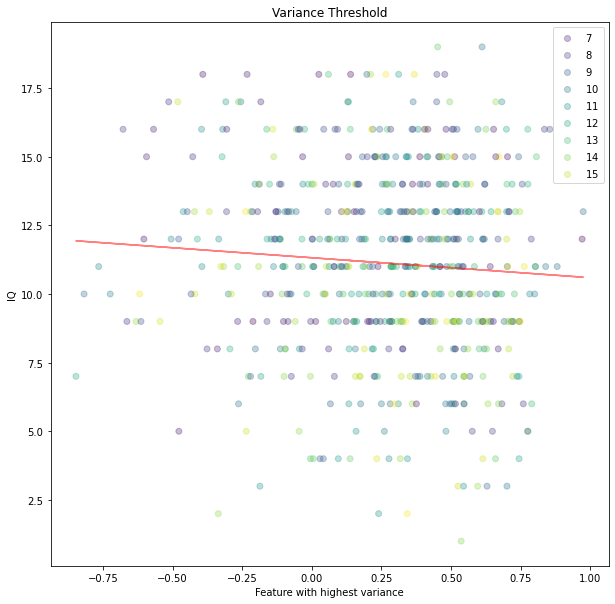

In [50]:
plt.figure(1, figsize=(10, 10))
scatter = plt.scatter(X_var_thres, y, c=ages, alpha=0.3, label='Ground Truth')
plt.plot(X_var_thres, y_var_thres, alpha=0.5, color='red', label="Predictions")
plt.title("Variance Threshold")
plt.xlabel('Feature with highest variance')
plt.ylabel('IQ')
plt.legend(*scatter.legend_elements())
plt.show()

In [51]:
X_mutual_info = SelectKBest(
    mutual_info_regression, k=1).fit_transform(X, y)

print(X_mutual_info.shape)

(577, 1)


In [52]:
reg = LinearRegression().fit(X_mutual_info, y)
y_mutual_info = reg.predict(X_mutual_info)

print("LR w/ Mutual Information:", reg.score(X_mutual_info, y))

LR w/ Mutual Information: 0.00016105738862803864


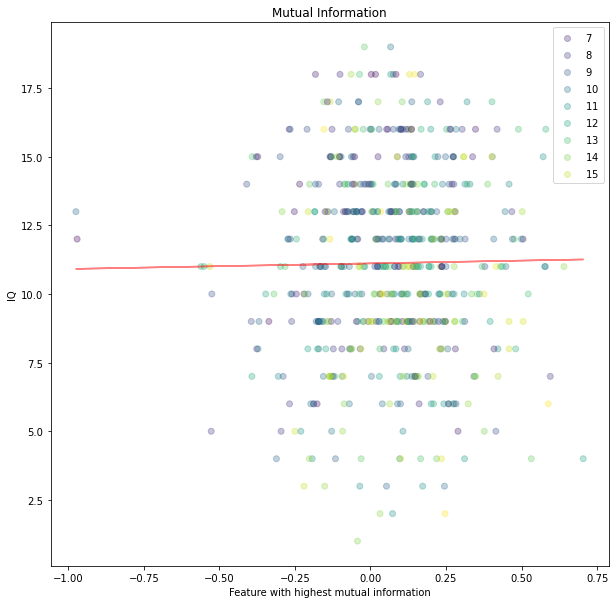

In [54]:
plt.figure(1, figsize=(10, 10))
scatter = plt.scatter(X_mutual_info, y, c=ages, alpha=0.3, label='Ground Truth')
plt.plot(X_mutual_info, y_mutual_info, alpha=0.5, color='red', label="Predictions")
plt.title("Mutual Information")
plt.xlabel('Feature with highest mutual information')
plt.ylabel('IQ') 
plt.legend(*scatter.legend_elements())
plt.show()